In [1]:
# Core Data Handling
import numpy as np
import pandas as pd
from collections import OrderedDict
from pandas_datareader import data as web
import yfinance as yf

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Statistical Tests
from statsmodels.tsa.stattools import adfuller
from scipy.stats import jarque_bera

# Non-Sequence Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Sequence Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import L1L2
import keras

# Model Evaluation
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Utility Functions
from typing import Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

##### Step 1. Data Preprocessing

In [2]:
# ===========================
# Load Data 
# ===========================
ticker = 'MCD'
start_date = '2015-01-01'
end_date = '2024-12-31'
market_data = (
    yf.download(ticker, start=start_date, end=end_date, 
                auto_adjust=True, progress=False)
    .pipe(lambda df: df.set_axis([col[0] for col in df.columns], axis=1))
    .join(
        yf.download(['^GSPC', '^VIX', 'GC=F', 'CL=F'], start=start_date, end=end_date, 
                    auto_adjust=True, progress=False)['Close']
        .rename(columns={'^GSPC': 'Benchmark', '^VIX': 'VIX', 'GC=F': 'Gold', 'CL=F': 'Crude_Oil'})
    )
    .dropna(how='all')
)

# Fama French
fama_french_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench',  start=start_date, end=end_date)[0]
fama_french_data.index = fama_french_data.index.to_timestamp() + pd.offsets.MonthEnd(0)
for col in fama_french_data.columns:
    if col == 'RF': 
        fama_french_data[col] = fama_french_data[col]/10
    else:
        fama_french_data[col] = fama_french_data[col]/100

# Combined dataframe        
market_data = market_data.merge(fama_french_data, left_index=True, right_index=True, how='left')
market_data = market_data.ffill().dropna()


# ===========================
# Feature Engineering
# ===========================
class FeatureEngineer:
    def __init__(self, lookback_window=90):
        self.lookback = lookback_window
        
    def add_features(self, df):
        df = self._add_price_features(df)
        df = self._add_technical_indicators(df)
        df = self._add_benchmark_features(df)
        df = self._add_market_features(df)
        df = self._add_seasonal_features(df)
        
        # Create binary target: 1 if next day's return is positive, 0 otherwise
        df['Target'] = (df['Close'].pct_change().shift(-1) > 0).astype(int)
        return df.dropna()
    
    def _add_price_features(self, df):       
        df['Daily_Return'] = df['Close'].pct_change()
        df['Intraday_Change'] = df['Close'] / df['Open'] - 1
        df['Overnight_Gap '] = df['Open'] - df['Close'].shift(1)
        df['EMA5'] = df['Close'].ewm(span=5, adjust=True).mean()
        df['EMA10'] = df['Close'].ewm(span=10, adjust=True).mean()
        df['EMA20'] = df['Close'].ewm(span=20,adjust=True).mean()
        df['EMA50'] = df['Close'].ewm(span=50, adjust=True).mean()
        df['EMA20/50_Ratio'] = df['EMA20'] / df['EMA50']
        df['Price_EMA_Ratio'] = df['Close'] / df['EMA20']
        return df
    
    def _add_technical_indicators(self, df):
        df['RSI14'] = self._calculate_rsi(df['Close'])
        df['MACD'] = self._calculate_macd(df['Close'])
        df['Upper_Band'] = df['EMA20'] + df['Close'].rolling(20).std()
        df['Lower_Band'] = df['EMA20'] - df['Close'].rolling(20).std()
        df['Bollinger_Band'] = (df['Close'] - df['Lower_Band'])/(df['Upper_Band'] - df['Lower_Band'])
        df['Volatility_21d'] = df['Daily_Return'].rolling(21).std() * np.sqrt(252) 
        df['Volatility_5d'] = df['Daily_Return'].rolling(5).std() * np.sqrt(252)
        df['Volatility_Ratio'] = df['Volatility_5d'] / df['Volatility_21d']
        return df

    def _add_benchmark_features(self, df):
        df['Daily_Return_Bench'] = df['Benchmark'].pct_change()
        df['Beta'] = self._calculate_beta(df['Close'], df['Benchmark'], df['RF'])
        df['Excess_Return'] = df['Daily_Return']-df['Daily_Return_Bench']
        df['Relative_Strength'] = df['Close'] / df['Benchmark']
        return df
    
    def _add_market_features(self, df):
        df['VIX_Change'] = df['VIX'].pct_change()
        df['Gold_Return'] = df['Gold'].pct_change()
        #df['Crude_Oil_Return'] = df['Crude_Oil'].pct_change()
        df['Gold_Correlation'] = df['Close'].rolling(21).corr(df['Gold'])
        return df
    
    def _add_seasonal_features(self, df):
        dates = df.index
        year_progress = dates.dayofyear / 365
        current_year = dates.year[0] 
        holiday_dates = [f'{current_year}-12-24', f'{current_year}-12-31', f'{current_year}-07-03', f'{current_year}-11-27']
        df['Year_sin'] = np.sin(2 * np.pi * year_progress)
        df['Year_cos'] = np.cos(2 * np.pi * year_progress)
        df['Month_sin'] = np.sin(2 * np.pi * dates.month/12)
        df['Month_cos'] = np.cos(2 * np.pi * dates.month/12)
        df['Week_sin'] = np.sin(2 * np.pi * dates.isocalendar().week/52)
        df['Week_cos'] = np.cos(2 * np.pi * dates.isocalendar().week/52)
        df['Month_end'] = dates.is_month_end.astype(int)
        df['Quarter_end'] = dates.is_quarter_end.astype(int)
        df['Year_end'] = dates.is_year_end.astype(int)
        df['Monday_effect'] = (dates.dayofweek == 0).astype(int)
        df['Friday_effect'] = (dates.dayofweek == 4).astype(int)
        df['First_day_month'] = (dates.day == 1).astype(int)
        df['Monthly_seasonality'] = df['Close'].pct_change().rolling(21).mean()
        df['Quarterly_seasonality'] = df['Close'].pct_change().rolling(63).mean()
        df['Annual_seasonality'] = df['Close'].pct_change().rolling(252).mean()
        df['Pre_holiday'] = dates.normalize().isin(
            pd.to_datetime(holiday_dates)
        ).astype(int)
        return df
    
    def _calculate_rsi(self, series, window=14):
        delta = series.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        
        avg_gain = gain.ewm(com=window-1, min_periods=window).mean()
        avg_loss = loss.ewm(com=window-1, min_periods=window).mean()
        
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))

    def _calculate_macd(self, series, fast=12, slow=26, signal=9):
        ema_fast = series.ewm(span=fast, adjust=False).mean()
        ema_slow = series.ewm(span=slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        return macd

    def _calculate_beta(self, stock, bench, risk_free):
        excess_stock = stock.pct_change() - risk_free / 252
        excess_bench = bench.pct_change() - risk_free / 252
        covariance = excess_stock.rolling(self.lookback).cov(excess_bench)
        variance = excess_bench.rolling(self.lookback).var()
        return covariance / variance
    

# ===========================
# Stationarity Check 
# ===========================
def check_stationarity(df):
    """Check and drop non-stationary series."""
    stationary_df = df.copy()
    dropped_cols = []

    for col in df.columns:
        p_val = adfuller(df[col].dropna())[1]
        if p_val >= 0.05: #non-stationary
            dropped_cols.append(col)
    stationary_df = stationary_df.drop(columns=dropped_cols)
    
    return stationary_df, dropped_cols

# ===========================
# Excecution 
# ===========================
# Apply feature engineering
engineer = FeatureEngineer()
processed_data = engineer.add_features(market_data)
stationary_df, dropped_cols = check_stationarity(processed_data)
print(f'Dropped factors:{dropped_cols}')
print(f'Remaining factors:{stationary_df.columns}')

Dropped factors:['Close', 'High', 'Low', 'Open', 'Crude_Oil', 'Gold', 'Benchmark', 'RF', 'EMA5', 'EMA10', 'EMA20', 'EMA50', 'Upper_Band', 'Lower_Band', 'Relative_Strength']
Remaining factors:Index(['Volume', 'VIX', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Daily_Return',
       'Intraday_Change', 'Overnight_Gap ', 'EMA20/50_Ratio',
       'Price_EMA_Ratio', 'RSI14', 'MACD', 'Bollinger_Band', 'Volatility_21d',
       'Volatility_5d', 'Volatility_Ratio', 'Daily_Return_Bench', 'Beta',
       'Excess_Return', 'VIX_Change', 'Gold_Return', 'Gold_Correlation',
       'Year_sin', 'Year_cos', 'Month_sin', 'Month_cos', 'Week_sin',
       'Week_cos', 'Month_end', 'Quarter_end', 'Year_end', 'Monday_effect',
       'Friday_effect', 'First_day_month', 'Monthly_seasonality',
       'Quarterly_seasonality', 'Annual_seasonality', 'Pre_holiday', 'Target'],
      dtype='object')


In [3]:
# ===========================
# Set Parameters
# ===========================
WINDOW_SIZE = 10
LOOK_AHEAD = 1
TRAIN_RATIO = 0.8
VAL_RATIO = 0.9  # Of the training set

# ===========================
# Split and Scale Data
# ===========================
def time_series_train_test_split(df, train_ratio, val_ratio):
    train_size = int(len(df) * train_ratio)
    val_size = int(train_size * val_ratio)
    
    train = df.iloc[:val_size]
    val = df.iloc[val_size:train_size]
    test = df.iloc[train_size:]
    
    return train, val, test

def create_sequences(data, features, target, window_size, look_ahead):
    X, y, y_dates = [], [], []
    for i in range(len(data) - window_size - look_ahead + 1):
        X.append(data[features].iloc[i:i+window_size].values)
        target_idx = i + window_size + look_ahead - 1
        y.append(data[target].iloc[target_idx])
        y_dates.append(data.index[target_idx])
    
    X_array = np.array(X)
    y_df = pd.DataFrame(y, index=pd.to_datetime(y_dates), columns=[target])
    return X_array, y_df[target].values.ravel()

# ===========================
# Main Pipeline
# ===========================
# Split data
train, val, test = time_series_train_test_split(stationary_df, TRAIN_RATIO, VAL_RATIO)

# Define features and target
features = stationary_df.columns.drop('Target')
target = 'Target'

# For non-sequence models
offset = WINDOW_SIZE + LOOK_AHEAD - 1
X_train, y_train = train[features].iloc[offset:], train[target].iloc[offset:]
X_val, y_val = val[features].iloc[offset:], val[target].iloc[offset:]
X_test, y_test = test[features].iloc[offset:], test[target].iloc[offset:]

# Scale features before windowing
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train[features])
val_features_scaled = scaler.transform(val[features])
test_features_scaled = scaler.transform(test[features])

# Create DataFrames with scaled features
train_scaled = train.copy()
train_scaled[features] = train_features_scaled
val_scaled = val.copy()
val_scaled[features] = val_features_scaled
test_scaled = test.copy()
test_scaled[features] = test_features_scaled

# Create sequences from scaled data
X_train_seq, y_train_seq = create_sequences(train_scaled, features, target, WINDOW_SIZE, LOOK_AHEAD)
X_val_seq, y_val_seq = create_sequences(val_scaled, features, target, WINDOW_SIZE, LOOK_AHEAD)
X_test_seq, y_test_seq = create_sequences(test_scaled, features, target, WINDOW_SIZE, LOOK_AHEAD)

# ===========================
# Verify Output
# ===========================
print(f"Train non-sequences: {X_train.shape}")
print(f"Validation non-sequences: {X_val.shape}")
print(f"Test non-sequences: {X_test.shape}")
print(f"Train sequences: {X_train_seq.shape}")
print(f"Validation sequences: {X_val_seq.shape}")
print(f"Test sequences: {X_test_seq.shape}")

Train non-sequences: (1575, 40)
Validation non-sequences: (167, 40)
Test non-sequences: (431, 40)
Train sequences: (1575, 10, 40)
Validation sequences: (167, 10, 40)
Test sequences: (431, 10, 40)


##### Step 2. Modeling

LOGISTIC Evaluation 
Accuracy       : 0.5329
Precision      : 0.5607
Recall         : 0.6593
F1             : 0.6061
Confusion Matrix:
[[29 47]
 [31 60]]
ROC AUC        : 0.4886


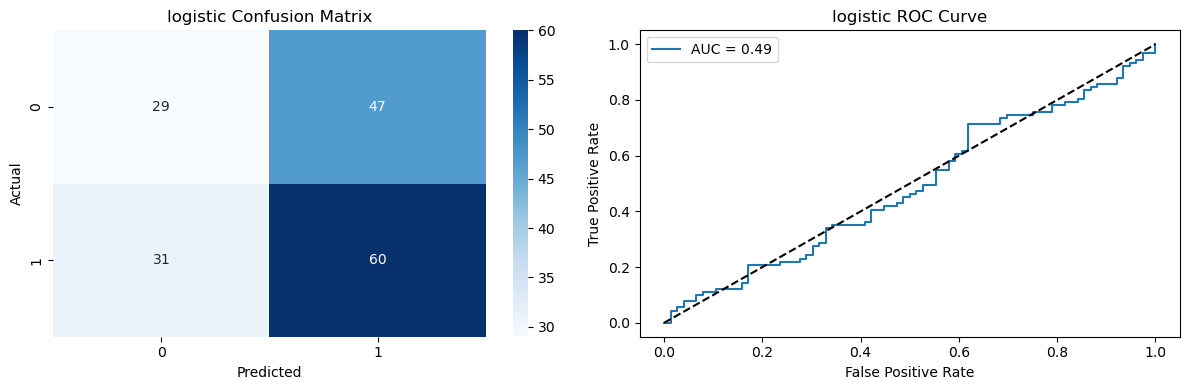

RF Evaluation 
Accuracy       : 0.5629
Precision      : 0.5918
Recall         : 0.6374
F1             : 0.6138
Confusion Matrix:
[[36 40]
 [33 58]]
ROC AUC        : 0.5175


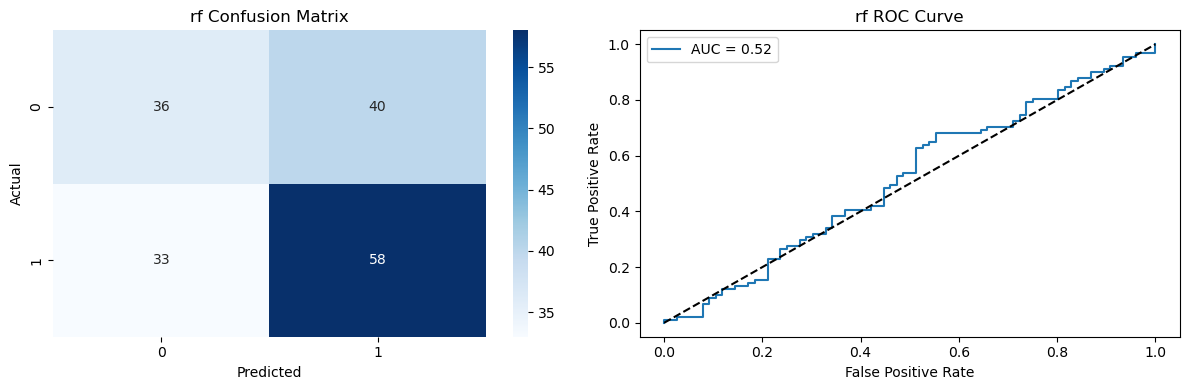

NN Evaluation 
Accuracy       : 0.5150
Precision      : 0.5385
Recall         : 0.7692
F1             : 0.6335
Confusion Matrix:
[[16 60]
 [21 70]]
ROC AUC        : 0.4427


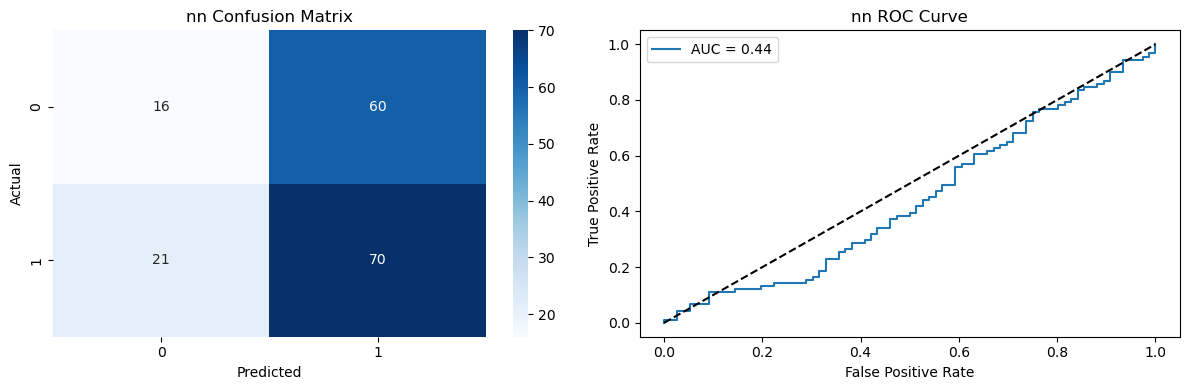

RNN Evaluation 
Accuracy       : 0.5210
Precision      : 0.5821
Recall         : 0.4286
F1             : 0.4937
Confusion Matrix:
[[48 28]
 [52 39]]
ROC AUC        : 0.5344


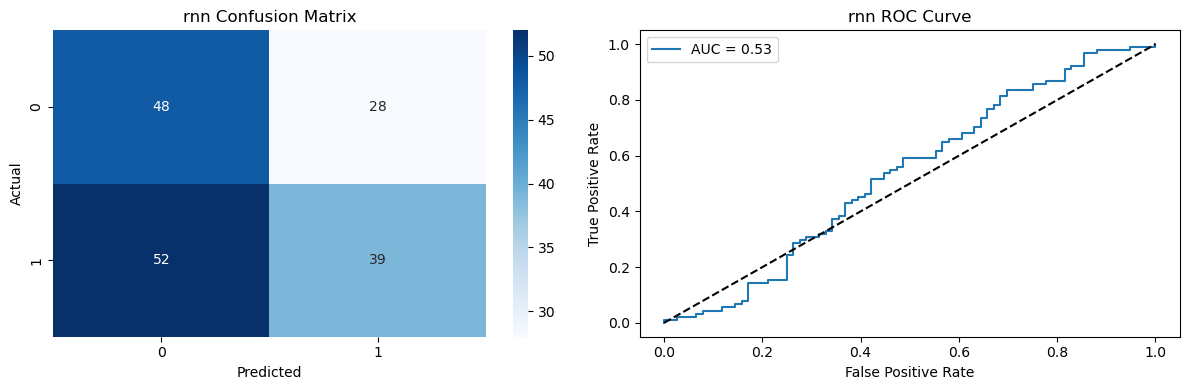

LSTM Evaluation 
Accuracy       : 0.5928
Precision      : 0.6353
Recall         : 0.5934
F1             : 0.6136
Confusion Matrix:
[[45 31]
 [37 54]]
ROC AUC        : 0.5831


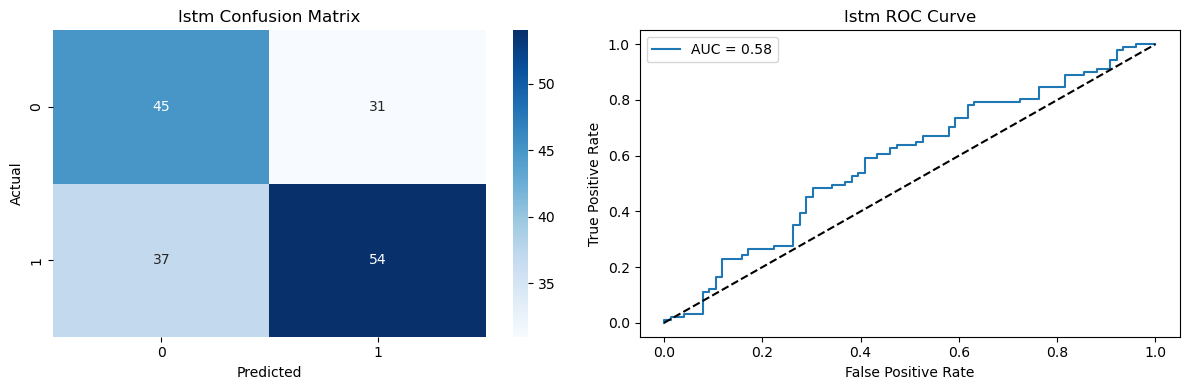


Model Comparison by F1:

nn          0.633484
rf          0.613757
lstm        0.613636
logistic    0.606061
rnn         0.493671
Name: F1, dtype: object


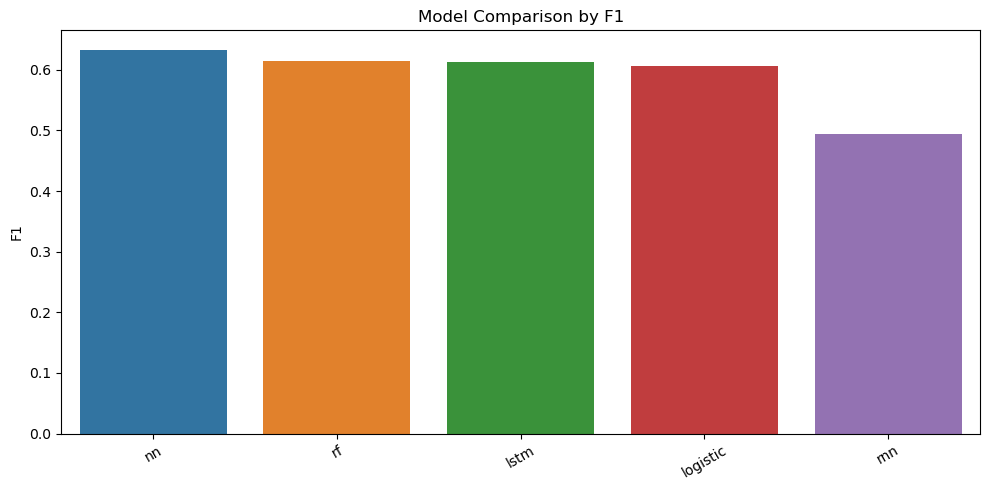

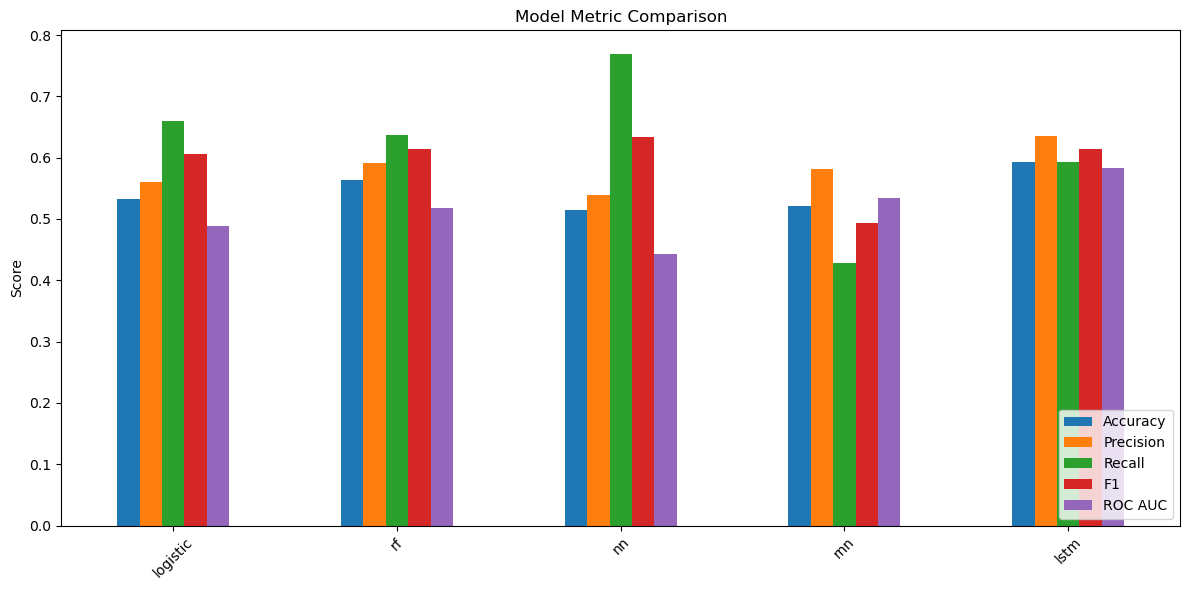

In [6]:
# ===========================
# Non-Sequence Models
# ===========================
def build_non_sequence_models():
    models = {
        'logistic': Pipeline([
            ('scaler', StandardScaler()),
            ('model', LogisticRegression(penalty='l2', C=0.1, solver='liblinear', class_weight='balanced', random_state=42))
        ]),
        'rf': RandomForestClassifier(
            n_estimators=300,
            max_depth=15,
            min_samples_split=10,
            min_samples_leaf=4,
            max_features='sqrt',
            class_weight='balanced_subsample',
            random_state=42,
            n_jobs=-1
        ),
        'nn': Pipeline([
            ('scaler', StandardScaler()),
            ('model', MLPClassifier(
                hidden_layer_sizes=(128, 64, 32),
                activation='relu',
                solver='adam',
                alpha=1e-4,
                early_stopping=True,
                random_state=42
            ))
        ])
    }
    return models

def train_evaluate_non_sequence(models, X_train, y_train, X_val, y_val):
    results = {}
    tscv = TimeSeriesSplit(n_splits=5)

    for name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='precision', n_jobs=-1)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None
        metrics = evaluate_classifier(y_val, y_pred, y_proba, name)
        results[name] = {
            'model': model,
            'metrics': metrics,
            'cv_accuracy': (cv_scores.mean(), cv_scores.std())
        }
    return results

# ===========================
# Sequence Models
# ===========================
def build_sequence_models(input_shape, dropout_rate=0.2):
    models = {}
    model_defs = {
        'rnn': [
            Input(shape=input_shape),
            BatchNormalization(),
            SimpleRNN(128, return_sequences=False),
            Dropout(dropout_rate),
            Dense(64, activation='relu'),
            Dropout(dropout_rate),
            Dense(1, activation='sigmoid')
        ],
        'lstm': [
            Input(shape=input_shape),
            BatchNormalization(),
            LSTM(128, return_sequences=True),
            Dropout(dropout_rate),
            LSTM(64, return_sequences=False),
            Dropout(dropout_rate),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ]
    }

    for name, layers in model_defs.items():
        model = Sequential(layers)
        model.compile(
            optimizer=Adam(learning_rate=0.005),
            loss='binary_crossentropy',
            metrics=['precision', 'AUC']
        )
        models[name] = model

    return models

def train_evaluate_sequence(models, X_train, y_train, X_val, y_val, batch_size=64, max_epochs=100):
    results = {}
    callbacks = [
        EarlyStopping(monitor='val_precision', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_precision', factor=0.2, patience=5, min_lr=1e-6)
    ]

    for name, model in models.items():
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=max_epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            shuffle=False,
            verbose=0
        )

        y_pred = (model.predict(X_val, verbose=0) > 0.5).astype(int).flatten()
        y_proba = model.predict(X_val, verbose=0).flatten()
        metrics = evaluate_classifier(y_val, y_pred, y_proba, name)
        results[name] = {
            'model': model,
            'metrics': metrics,
            'history': history.history,
            'actual_vs_pred': pd.DataFrame({'Actual': y_val, 'Predicted': y_pred})
        }
    return results

# ===========================
# Evaluation and Comparison
# ===========================
def evaluate_classifier(y_true, y_pred, y_proba=None, model_name=""):
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1': f1_score(y_true, y_pred),
        'Confusion Matrix': confusion_matrix(y_true, y_pred)
    }

    if y_proba is not None:
        metrics['ROC AUC'] = roc_auc_score(y_true, y_proba)

    print(f"\n{model_name.upper()} Evaluation \n".center(50, '='))
    for k, v in metrics.items():
        print(f"{k}:\n{v}" if k == 'Confusion Matrix' else f"{k:<15}: {v:.4f}")

    fig, axes = plt.subplots(1, 2 if y_proba is not None else 1, figsize=(12, 4))
    sns.heatmap(metrics['Confusion Matrix'], annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f"{model_name} Confusion Matrix")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        axes[1].plot(fpr, tpr, label=f"AUC = {metrics['ROC AUC']:.2f}")
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title(f"{model_name} ROC Curve")
        axes[1].legend()

    plt.tight_layout()
    plt.show()
    return metrics

def compare_models(results, metric='Accuracy'):
    metrics_df = pd.DataFrame({name: res['metrics'] for name, res in results.items()}).T
    print(f"\nModel Comparison by {metric}:\n")
    sorted_metrics = metrics_df[metric].sort_values(ascending=False)
    print(sorted_metrics)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=sorted_metrics.index, y=sorted_metrics.values)
    plt.title(f"Model Comparison by {metric}")
    plt.ylabel(metric)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    return results[sorted_metrics.idxmax()]['model'], metrics_df

def plot_all_model_metrics(metrics_df, metrics=["Accuracy", "Precision", "Recall", "F1", "ROC AUC"]):
    metrics_df[metrics].plot(kind='bar', figsize=(12, 6))
    plt.title("Model Metric Comparison")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# ===========================
# Execution
# ===========================
if __name__ == "__main__":
    non_seq_models = build_non_sequence_models()
    non_seq_results = train_evaluate_non_sequence(non_seq_models, X_train, y_train, X_val, y_val)

    seq_models = build_sequence_models(X_train_seq.shape[1:])
    seq_results = train_evaluate_sequence(seq_models, X_train_seq, y_train_seq, X_val_seq, y_val_seq)

    all_results = {**non_seq_results, **seq_results}
    best_model_f1, metrics_df = compare_models(all_results, metric='F1')
    plot_all_model_metrics(metrics_df)

##### Step 3. Backtesting

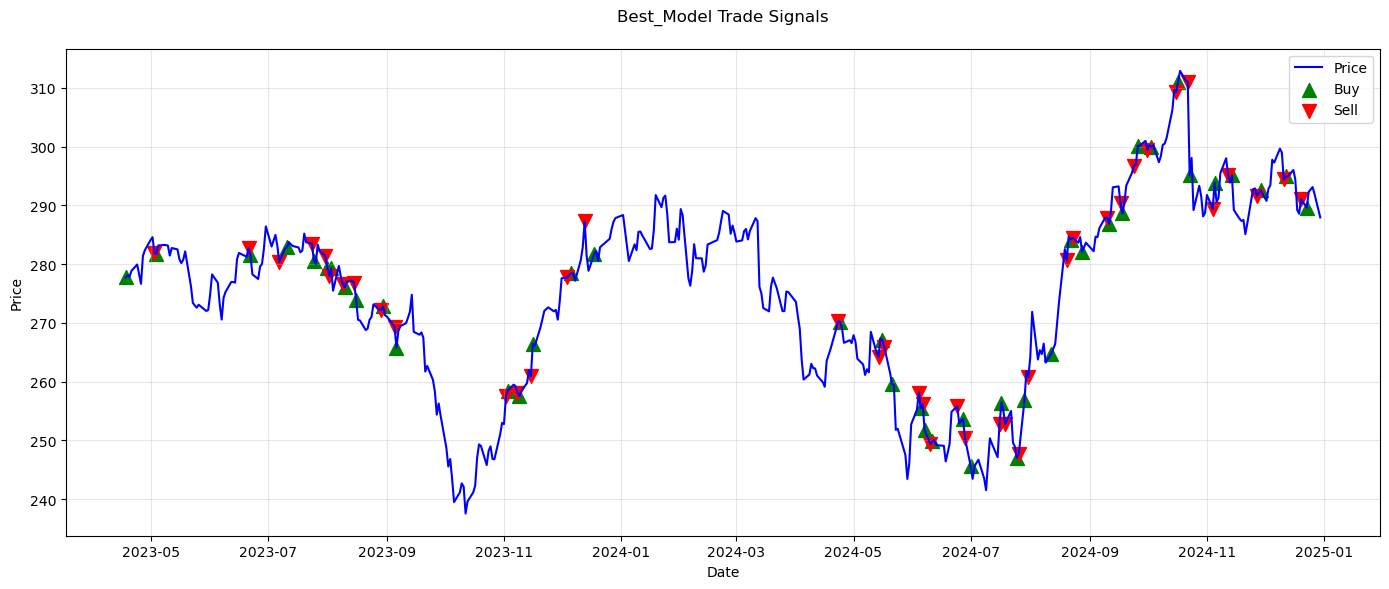

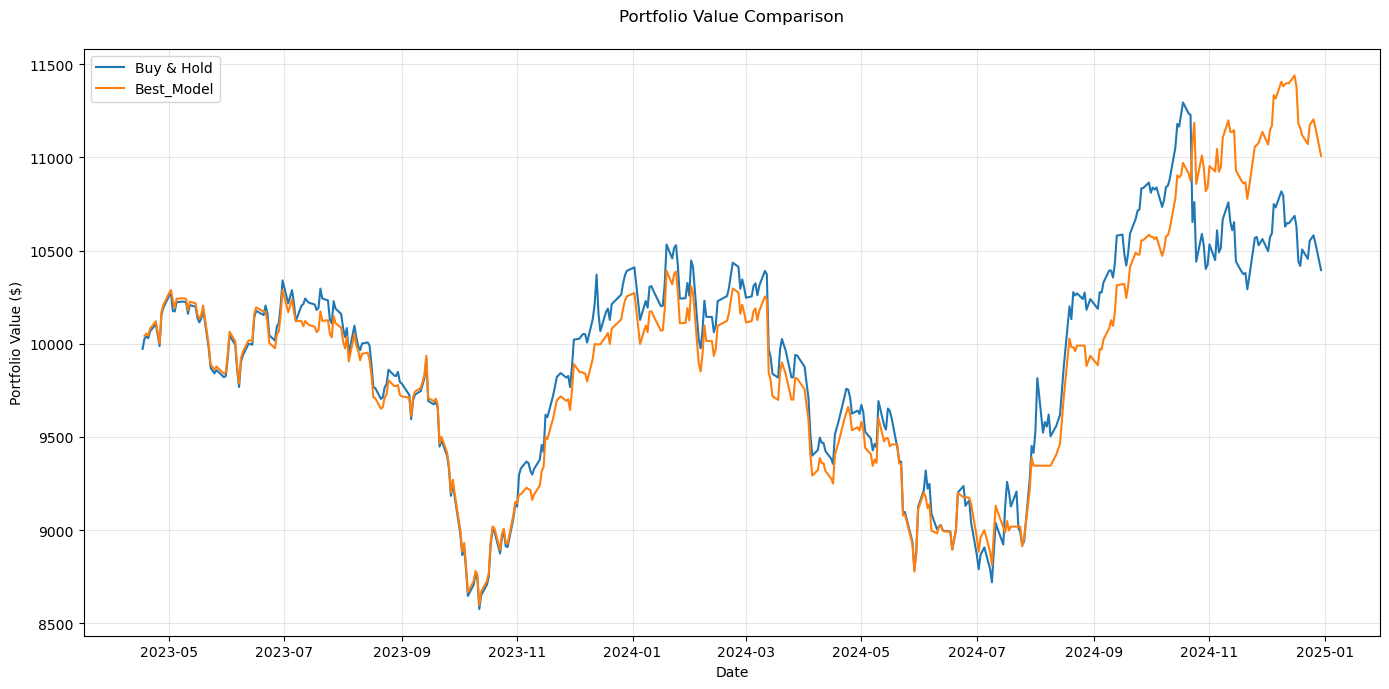


=== Performance Metrics ===


,Buy & Hold,Best_Model
Final Value,"$10,395.07","$11,007.69"
Cumulative Return,3.95%,10.08%
Annualized Return,2.30%,5.82%
Volatility,16.09%,14.05%
Sharpe Ratio,-0.04,0.20
Max Drawdown,17.21%,16.46%
Trades,1.00,80.00
Win Rate,N/A,53.72%


In [7]:
def calculate_buy_and_hold(prices, initial_balance=10000, transaction_cost=0.001, risk_free_rate=0.03):
    """Simulate a buy-and-hold strategy and compute key performance metrics."""
    if not isinstance(prices, pd.DataFrame) or not {'Open', 'Close'}.issubset(prices.columns):
        raise ValueError("Input must be a DataFrame with 'Open' and 'Close' columns.")
    
    cash = initial_balance
    shares = 0
    portfolio_values = [initial_balance]

    for i, row in prices.iterrows():
        if i == prices.index[0]:
            shares = cash / (row['Open'] * (1 + transaction_cost))
            cash = 0
        portfolio_values.append(cash + shares * row['Close'])

    portfolio_series = pd.Series(portfolio_values[1:], index=prices.index)
    returns = portfolio_series.pct_change().dropna()
    
    cumulative_return = (portfolio_series.iloc[-1] / initial_balance) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(prices)) - 1
    volatility = returns.std() * np.sqrt(252)
    max_drawdown = ((portfolio_series.cummax() - portfolio_series) / portfolio_series.cummax()).max()

    return {
        'dates': prices.index,
        'portfolio_values': portfolio_series,
        'performance': {
            'final_value': portfolio_series.iloc[-1],
            'cumulative_return': cumulative_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'max_drawdown': max_drawdown,
            'num_trades': 1,
            'sharpe_ratio': (annualized_return - risk_free_rate) / volatility if volatility else np.nan
        }
    }

def backtest_model(best_model, X_test, X_test_seq, features, prices, y_test,
                   initial_balance=10000, transaction_cost=0.001, risk_free_rate=0.03):
    """Simulate a model-based trading strategy using simple all-in logic and return performance."""
    if len(prices) < 2:
        raise ValueError("Prices must contain at least 2 periods for backtesting.")
    
    is_seq_model = hasattr(best_model, "input_shape")
    X_input = X_test_seq if is_seq_model else X_test

    def predict_model(model, X):
        if hasattr(model, 'predict_proba'):
            probs = model.predict_proba(X)[:, 1]
        else:
            probs = model.predict(X).flatten()
        return (probs > 0.5).astype(int), probs

    preds, probs = predict_model(best_model, X_input)

    if len(preds) != len(prices) + 1:
        raise ValueError("Predictions length mismatch: expected len(preds) == len(prices) + 1")

    cash, shares = initial_balance, 0
    portfolio_values = [initial_balance]
    buy_signals, sell_signals = [], []

    for i in range(1, len(prices)):
        open_price = prices['Open'].iloc[i]
        close_price = prices['Close'].iloc[i]
        pred = preds[i - 1]

        if pred == 1 and cash > open_price:
            max_shares = cash // (open_price * (1 + transaction_cost))
            if max_shares > 0:
                cost = max_shares * open_price * (1 + transaction_cost)
                shares += max_shares
                cash -= cost
                buy_signals.append(prices.index[i])
        elif pred == 0 and shares > 0:
            proceeds = shares * open_price * (1 - transaction_cost)
            cash += proceeds
            shares = 0
            sell_signals.append(prices.index[i])

        portfolio_values.append(cash + shares * close_price)

    portfolio_series = pd.Series(portfolio_values[1:], index=prices.index[1:])
    returns = portfolio_series.pct_change().dropna()

    if returns.empty:
        raise ValueError("No trades were executed during backtesting.")

    cumulative_return = (portfolio_series.iloc[-1] / initial_balance) - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(returns)) - 1
    volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility else np.nan
    max_drawdown = ((portfolio_series.cummax() - portfolio_series) / portfolio_series.cummax()).max()

    win_rate = accuracy_score(y_test[:len(preds)], preds) if is_seq_model else \
               accuracy_score(y_test.iloc[1:len(preds)+1], preds[:len(y_test)-1])
    num_trades = int(np.sum(np.abs(np.diff(np.where(preds == 1, 1, 0)))))

    return {
        'dates': prices.index[1:],
        'portfolio_values': portfolio_series,
        'performance': {
            'final_value': portfolio_series.iloc[-1],
            'cumulative_return': cumulative_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': num_trades,
            'win_rate': win_rate
        },
        'predictions': preds,
        'buy_signals': buy_signals,
        'sell_signals': sell_signals,
        'price_series': prices['Close'].iloc[1:]
    }

def compare_models(model_dict, features, X_test, X_test_seq, y_test, y_test_seq,
                   market_data, initial_balance=10000, transaction_cost=0.001, risk_free_rate=0.03):
    """Compare all models to buy-and-hold strategy."""
    prices = market_data[['Open', 'Close']].loc[y_test.index[1:]].copy()
    if prices.empty:
        raise ValueError("No price data for test period.")

    bh_results = calculate_buy_and_hold(prices, initial_balance, transaction_cost, risk_free_rate)

    model_results = {}
    for name, model in model_dict.items():
        try:
            model_results[name] = backtest_model(
                best_model=model,
                X_test=X_test,
                X_test_seq=X_test_seq,
                features=features,
                prices=prices,
                y_test=y_test_seq if hasattr(model, "input_shape") else y_test,
                initial_balance=initial_balance,
                transaction_cost=transaction_cost,
                risk_free_rate=risk_free_rate
            )
        except Exception as e:
            print(f"[{name}] Backtest Error: {e}")
            continue

    return bh_results, model_results

def plot_trade_signals(price_series, buy_signals, sell_signals, title="Stock Price with Trade Signals"):
    """Visualize stock price with annotated trade signals."""
    plt.figure(figsize=(14, 6))
    plt.plot(price_series.index, price_series.values, label='Price', color='blue')
    if buy_signals:
        plt.scatter(buy_signals, price_series.loc[buy_signals], marker='^', color='green', label='Buy', s=100)
    if sell_signals:
        plt.scatter(sell_signals, price_series.loc[sell_signals], marker='v', color='red', label='Sell', s=100)
    plt.title(title, pad=20)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def visualize_comparison(bh_results, model_results):
    """Plot portfolio values and compare key performance metrics."""
    all_results = {'Buy & Hold': bh_results, **model_results}
    
    # Plot portfolio value over time
    plt.figure(figsize=(14, 7))
    for name, result in all_results.items():
        plt.plot(result['dates'], result['portfolio_values'], label=name)
    plt.title('Portfolio Value Comparison', pad=20)
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Display performance metrics
    metrics = ['final_value', 'cumulative_return', 'annualized_return',
               'volatility', 'sharpe_ratio', 'max_drawdown', 'num_trades', 'win_rate']
    names = ['Final Value', 'Cumulative Return', 'Annualized Return',
             'Volatility', 'Sharpe Ratio', 'Max Drawdown', 'Trades', 'Win Rate']
    metrics_df = pd.DataFrame(index=names)

    for name, result in all_results.items():
        metrics_df[name] = [result['performance'].get(m, np.nan) for m in metrics]

    def format_metric(x, metric_name=None):
        if pd.isna(x): return 'N/A'
        if isinstance(x, (float, np.floating)):
            if metric_name == 'sharpe_ratio':
                return f"{x:.2f}"
            elif abs(x) < 1:
                return f"{x:.2%}"
            elif x > 1000:
                return f"${x:,.2f}"
            return f"{x:.2f}"
        return f"{x:,}" if isinstance(x, (int, np.integer)) else x

    print("\n=== Performance Metrics ===")
    display(metrics_df.apply(lambda col: [format_metric(x, m) for x, m in zip(col, metrics)], axis=0))

# Sample entry point
if __name__ == "__main__":
    models_to_test = {
        'Best_Model': best_model_f1,
    }

    bh_results, model_results = compare_models(
        model_dict=models_to_test,
        features=features,
        X_test=X_test,
        X_test_seq=X_test_seq,
        y_test=y_test,
        y_test_seq=y_test_seq,
        market_data=market_data,
        initial_balance=10000,
        transaction_cost=0.001,
        risk_free_rate=0.03
    )

    for name, result in model_results.items():
        plot_trade_signals(result['price_series'], result['buy_signals'], result['sell_signals'], title=f"{name} Trade Signals")

    visualize_comparison(bh_results, model_results)
